#Cognitive architectures for self regulation and motivation

In this tutorial we develop a basic building block of a neural cognitive architecture for self regulation from the balance point of view.

Hypothalamic circuits are known to provide a motivational controller for mammals that allows for the satisfaction of basic needs and therefor the regulation of physiological variables required for survival. In this tutorial we implement a basic neuronal model that is a building block for the implementation of such controller in artifical agents.

**Learning objectives**    

1.   Understand the basic principles of self regulation of temperature in   mammals
2.   Identify the main neuronal components of low level neural mechanisms of self-regulation from the balance point of view
3. Implement the Hammel model as a neuronal motivational motif
4. Use the Hammel model to perform set-point control in a simulated agent.



**Section 0: Introducing the IRobotCom interface**


---



In [35]:
#@title Imports
from IPython.display import IFrame, Javascript, HTML, display
import IPython
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time
from google.colab import output

matplotlib.rcParams['figure.figsize'] = [8, 5]
matplotlib.rcParams['text.usetex'] = False

The IRobotCom interface provides the infrastructure to control a robot using the webots simulator

In [36]:
#@title IRobotCom interface

class RobotCom(object):
  def __init__(self):
    self.temperature_gradient = 0.15
    self.temperature_intercept = float(40)
    self.temperature = self.temperature_intercept
    self.topic_list = []
    self.channelsHTML = ""
    self.R = HTML('''<iframe id="simulator" src="https://127.0.0.1:8080/" width="620" height="620">
                      </iframe>
                      <script src="https://127.0.0.1:8080/irobotcom.js"></script>
                  ''')

  def subscribe( self, callback ):
    output.register_callback('notebook.Run', callback)

  def registerTopic(self, topic):
    if topic not in self.topic_list:
      self.channelsHTML += "<script>const sender_" + str(topic) + "_channel = new BroadcastChannel('" + str(topic) + "');</script>"
      self.topic_list.append(topic)

  def initCell( self ):
    display(HTML(self.channelsHTML))

  def publish(self, topic, msg):
    js_pub_msg = "<script>var msg = '" + str(msg) + "';sender_" + str(topic) + "_channel.postMessage(msg);</script>"
    display(HTML(js_pub_msg))

  def show_interface(self):
    display(self.R)
    # self.publish("temperature_gradient", self.temperature_gradient)
    # self.publish("temperature_intercept", self.temperature_intercept)

  def reset(self):
    self.publish("control", "reset")

  def start(self):
    self.publish("control", "start")

  def pause(self):
    self.publish("control", "pause")


myRobot = RobotCom()
myRobot.registerTopic("control")
myRobot.registerTopic("speed")
myRobot.registerTopic("temperature_gradient")
myRobot.registerTopic("temperature_intercept")
myRobot.initCell()
myRobot.show_interface()

Initialize the simulator

In [37]:
myRobot.initCell()
myRobot.reset()
print("Simulation reset")

Simulation reset


The simulation can be paused in any moment

In [41]:
myRobot.initCell()
myRobot.pause()
print("Simulation paused")

Simulation paused


**Section 1: Testing the robot interface**

---


Let's start by testing the interface. The current robot is a simple agent with one physiological variable: temperature, whose value is sent at each time step to a callback function that contains the control commands we want to send.  The agent's behaviour is rather simple in this case.

In [38]:
myRobot.initCell()
temp = []

def run( temperature ):

  if len(temp) > 1000:
    myRobot.publish('speed', 0)
    myRobot.pause()
    return
  # Change the speed
  myRobot.publish('speed', 1)
  # output.clear(output_tags='some_outputs')
  myRobot.temperature = float(temperature)
  temp.append(myRobot.temperature)

  # with output.use_tags('some_outputs'):

myRobot.subscribe( run )
myRobot.start( )

Plotting the results

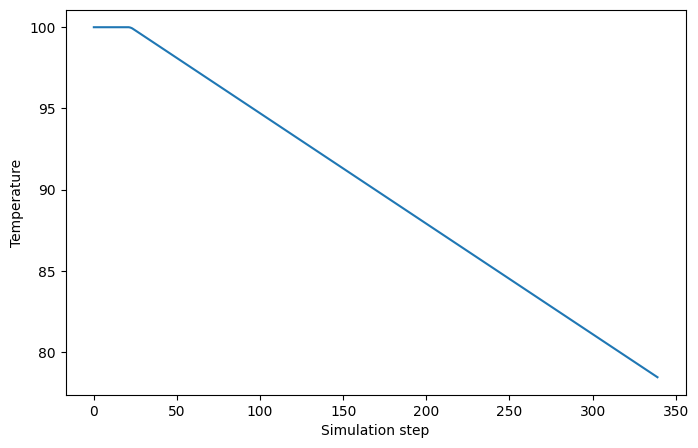

In [39]:
plt.plot(temp)
plt.xlabel("Simulation step")
plt.ylabel("Temperature")
plt.show()

**Adjust Robot Environment**

Apart from controlling the robot we can also control the robot's environment. In this case, the robot perceives the temperature gradient with its temperature receptors.

In [ ]:
#@title Adjust Robot Environment { run: "auto", display-mode: "form" }
#@title  { run: "auto" }
# modify temperature gradient
myRobot.initCell()
temperature_gradient = 0.51 #@param {type:"slider", min:0.01, max:1, step:0.01}
myRobot.temperature_gradient = temperature_gradient
myRobot.publish("temperature_gradient", myRobot.temperature_gradient)
# modify temperature intercept
temperature_intercept = 30 #@param {type:"slider", min:30, max:50, step:1}
myRobot.temperature_intercept = temperature_intercept
myRobot.publish("temperature_intercept", myRobot.temperature_intercept)

**Section 2: Hammel mechanism**

---

In order to implement primitive adaptive behaviour, we implement a simple neuronal model for set-point-like control based on I-E balance.


**Warm and Cold receptors**



The first step is to implement our robot's interface with the physiological environment. Based upon the literature on thermal touch, we define warm and cold receptors as nonlinear functions of the environment's temperature:


$A(T) = \frac{1}{1+ \exp(\sigma(T - T_0))}$

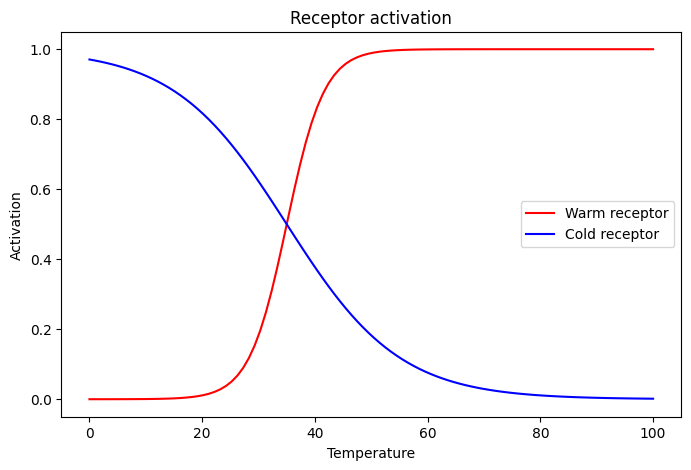

In [42]:
sigma_w = 0.3
sigma_c = 0.1
response_w = lambda T: 1.0/(1 + np.exp(-sigma_w*(T - 35.0)))
response_c = lambda T: 1.0/(1 + np.exp(sigma_c*(T - 35.0)))

temps = np.linspace(0, 100, 100)

plt.plot(temps, response_w(temps), 'r',  label = "Warm receptor")
plt.plot(temps, response_c(temps), 'b', label = "Cold receptor")
plt.title('Receptor activation')
plt.xlabel('Temperature')
plt.ylabel('Activation')
plt.legend()
plt.show()

**Neurons**

We now need some neurons to implement the neural circuit as described in the tutorial. In this case we use rate neurons, and the following are two examples:

Text(0.5, 0, 'activation')

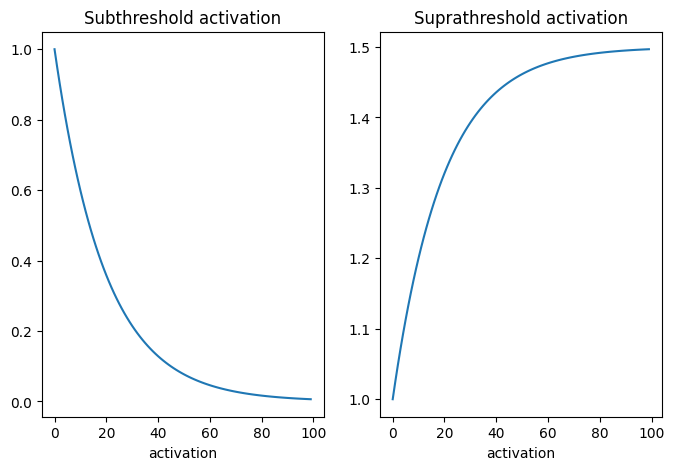

In [43]:
h = 0.1
w = 1.0
tau = 2.0
g = lambda x: x*(x > 1.0)
dneuron = lambda x, I:  (-x + g( w*I ))/tau

T = 100
X1 = np.zeros(T)
X2 = np.zeros(T)
X1[0] = 1.0
X2[0] = 1.0
I1 = 0.5
I2 = 1.5

for i in range(T-1):
  X1[i+1] = X1[i] + h*dneuron(X1[i], I1)
  X2[i+1] = X2[i] + h*dneuron(X2[i], I2)

fig, ax = plt.subplots(1, 2)

ax[0].plot(X1)
ax[0].set_title('Subthreshold activation')
ax[0].set_xlabel('time step')
ax[0].set_xlabel('activation')

ax[1].plot(X2)
ax[1].set_title('Suprathreshold activation')
ax[1].set_xlabel('time step')
ax[1].set_xlabel('activation')

**Neural circuit**

Now we define the Hammel's mechanism as described in the tutorial. We will creating creating a class that can be reused for future purposes.

The basic circuit for the Hammel mechanism is shown if the figure:

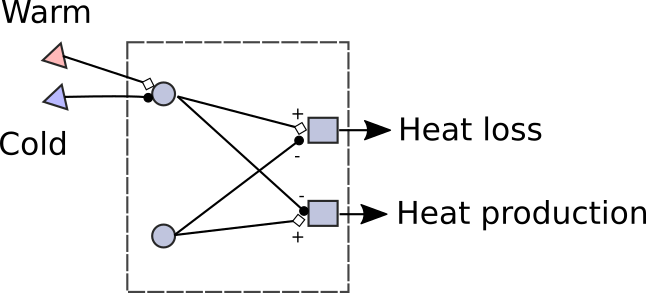
.

It is composed of a spinal neuron that receives excitatory and inhibitory connections from the warm and cold receptors respectivelly. Such neuron excites warm sensitive neurons in the hypothalamus. The output of warm sensitive neurons competes with warm insensitive neurons to generate the activation of action cells that lead to warm-seeking or cold-seeking behaviours.


In [44]:
class Hammel:
  def __init__(self):
    # Receptors
    self.h = 0.08
    sigma = 0.1
    self.response_w = lambda T: 1.0/(1 + np.exp(-0.1*(T - 35.0)))
    self.response_c = lambda T: 1.0/(1 + np.exp(0.1*(T - 30.0)))
    # Activation
    self.g = lambda x: x*(x > 0.0)
    # State
    self.X = np.array([0, 0, 1, 0, 0])
    self.t = 0.0

  def f( self, t, x, T):
    w_warm = w_cold = w_sp_sen = w_sen_w = w_ins_w = w_sen_c = w_ins_c = 2.0
    sp = x[0]
    sen = x[1]
    ins = x[2]
    w = x[3]
    c = x[4]

    d_sp = lambda x: (-(x - 0) + self.g( w_warm*self.response_w(T) - w_cold*self.response_c(T)))/tau
    d_sen = lambda x: (-x + self.g( w_sp_sen*sp))/tau
    d_ins = lambda x: 0
    d_w = lambda x: (-x + self.g( w_sen_w*sen - w_ins_w*ins))/tau
    d_c = lambda x: (-x + self.g( -w_sen_c*sen + w_ins_c*ins))/tau

    return np.array([d_sp(sp), d_sen(sen), d_ins(ins), d_w(w), d_c(c)])

  def step( self, temperature ):
    self.X = self.X + self.h*self.f(self.t, self.X, temperature)
    self.t = self.t + self.h

    return self.t, self.X



To test our circuit, we integrate the equations for a given example temperature. (Try some other values to study the behaviour)

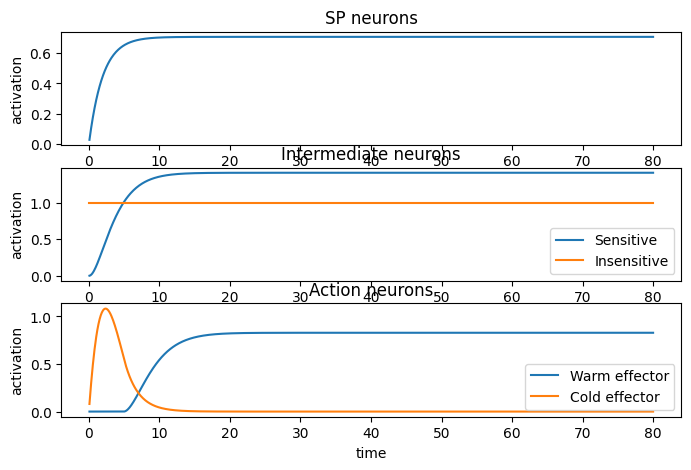

In [45]:

NT = 1000
X = np.zeros((5, NT))
t = np.zeros(NT)
hammel = Hammel()
temperature = 40

for i in range(NT):
  t[i], X[:,i] = hammel.step(temperature)

# Plotting
fig, ax = plt.subplots(3, 1)

ax[0].plot(t, X[0, :])
ax[0].set_title('SP neurons')
ax[0].set_xlabel('time')
ax[0].set_ylabel('activation')
ax[1].plot(t, X[1, :], label = 'Sensitive')
ax[1].plot(t, X[2, :], label = 'Insensitive')
ax[1].set_title('Intermediate neurons')
ax[1].set_xlabel('time')
ax[1].set_ylabel('activation')
ax[1].legend()

ax[2].plot(t, X[3, :], label = 'Warm effector')
ax[2].plot(t, X[4, :], label = 'Cold effector')
ax[2].set_title('Action neurons')
ax[2].set_xlabel('time')
ax[2].set_ylabel('activation')
ax[2].legend()

Additionally, we can integrate the model for a whole range of temperatures and see how the steady state changes as a function of temperature.

Text(0.5, 1.0, 'Heat seeking effector')

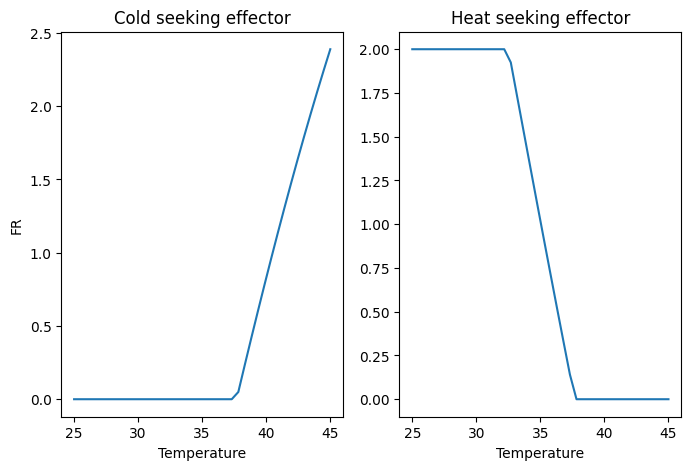

In [46]:
NT = 500
NP = 40
temperatures = np.linspace(25, 45, NP)
w_fr = np.zeros(NP)
c_fr = np.zeros(NP)
hammel = Hammel()

for j in range(NP):
  X = np.zeros((5, NT))
  t = np.zeros(NT)

  for i in range(NT):
    t[i], X[:,i] = hammel.step(temperatures[j])

  w_fr[j] = X[3,-1]
  c_fr[j] = X[4,-1]


fig, ax = plt.subplots(1, 2)

ax[0].plot(temperatures, w_fr)
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('FR')
ax[0].set_title('Cold seeking effector')
ax[1].plot(temperatures, c_fr)
ax[1].set_xlabel('Temperature')
ax[1].set_title('Heat seeking effector')

**Section 3: Putting everything together**

---

Finally we are ready to embody our model in the robot simulator using the OpenRobotSim interface. Similar to what we did before, we define a *run* function with the logic of our robot. In this case we use the cold and heat seeking effectors to drive its simple behaviour.

In [47]:
myRobot.initCell()
myRobot.reset()

In [48]:
# # Show a new instance of the simulator
myRobot.initCell()
hammel = Hammel()
temp = []

def run2( temperature ):
  t, X = hammel.step( float(temperature) )
  # Change the speed
  w_fr = X[3]
  c_fr = X[4]

  myRobot.publish('speed', w_fr - c_fr)
  # if w_fr > 0.5:
  #   myRobot.publish('speed', 1)
  # elif c_fr > 0.5:
  #   myRobot.publish('speed', -1)
  # else:
  #   myRobot.publish('speed', 0)

  # output.clear(output_tags='temp_graph')
  temp.append(float(temperature))

  # with output.use_tags('temp_graph'):

myRobot.subscribe( run2 )
myRobot.start()
print("Running simulation - check the simulator")

Running simulation - check the simulator


Plotting the results

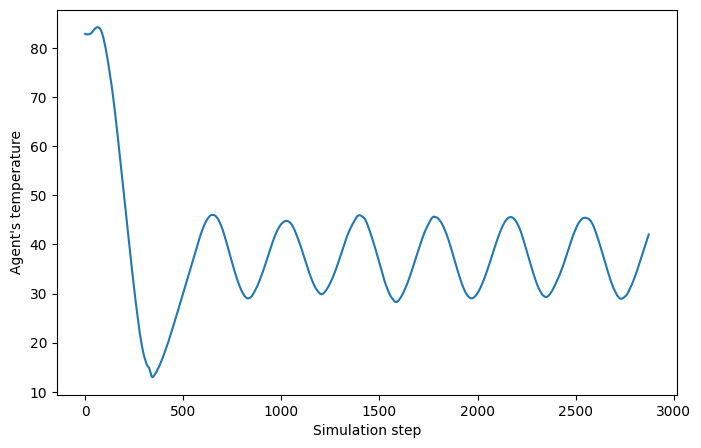

In [51]:
plt.plot(temp)
plt.xlabel("Simulation step")
plt.ylabel("Agent's temperature")
plt.show()

**Section 4: Exercises**


---



1. Add a perturbation by changing the intercept or slope of the gradient.

2. How would you add multiple behaviours in this framework? Would this mechanism work for all kinds of motivations?